In [1]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import os
os.chdir("drive/")
os.chdir('My Drive')
os.chdir('Research')

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Aug 15 11:28:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Write a script to train a small CNN on MNIST, or find one you have written previously.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
import seaborn as sns
import pandas as pd
import scipy.stats as stats

In [5]:
def set_seed(seed):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

set_seed(42)

In [6]:
batch_size = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [7]:
#Loading the dataset and preprocessing
train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True,
                                           transform=transforms.Compose([
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1307,), std = (0.3081,))]),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data',
                                          train=False,
                                          transform=transforms.Compose([
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1307,), std = (0.3081,))]),
                                          download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [8]:
#Defining the small CNN
class ConvNet(nn.Module):
    def __init__(self, dropout=0.0):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 3, kernel_size=3)
        self.fc = nn.Linear(192, 10)
        self.dropout = nn.Dropout(dropout)

        self.num_params = sum(p.numel() for p in self.parameters())
        print(f"num params: {self.num_params}")

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 3))
        x = x.view(-1, 192)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [9]:
model = ConvNet().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.01)

num params: 1960


In [10]:
def train(model, optimizer):
    model.train()
    print(f"training model with {model.num_params} parameters")
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for it, (images, labels) in pbar:  
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        
        outputs = model(images)
        loss = loss_fn(outputs, labels)
            
        loss.backward()
        optimizer.step()

        pbar.set_description(f"iter {it}: train loss {loss.item():.5f}")

train(model, optimizer)

training model with 1960 parameters


iter 468: train loss 0.10330: 100%|██████████| 469/469 [00:17<00:00, 27.35it/s]


In [11]:
def test(model):
    model.eval()
    print(f"testing model with {model.num_params} parameters")
    with torch.no_grad():
        correct = 0
        total = 0
        test_loss = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            test_loss += loss_fn(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        test_loss /= len(test_loader)
        print(f"test loss: {test_loss}")
        print(f"Accuracy of the network on the 10000 test images: {correct / total}")
        return test_loss, correct / total

test(model)

testing model with 1960 parameters
test loss: 0.1755315891549557
Accuracy of the network on the 10000 test images: 0.9479


(0.1755315891549557, 0.9479)

## Training for a single epoch only, vary the model size and dataset size. For the model size, multiply the width by powers of sqrt(2) (rounding if necessary - the idea is to vary the amount of compute used per forward pass by powers of 2). To reduce noise, use a few random seeds and always use the full validation set.

In [12]:
# modify CNN model to scale width by scaling_factor
class WideConvNet(nn.Module):
    def __init__(self, scaling_factor, dropout=0.0):
        super().__init__()
        self.scaling_factor = scaling_factor
        self.conv1 = nn.Conv2d(1, int(3 * scaling_factor), kernel_size=3)
        self.fc = nn.Linear(int(3 * scaling_factor) * 64, 10)
        self.dropout = nn.Dropout(dropout)

        self.num_params = sum(p.numel() for p in self.parameters())
        print(f"num params: {self.num_params}")

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 3))
        x = x.view(-1, int(3 * self.scaling_factor) * 64)
        x = self.dropout(x)
        x = self.fc(x)
        return x

Note: for learning rates, I'll use the rule of thumb from [Scaling Laws for Neural Language Models](https://arxiv.org/abs/2001.08361)

In [13]:
def LR(N):
    return 0.003239  + ((-0.0001395) * math.log(N))

In [14]:
# now train / test different sized models to observe scaling laws
# scaling factors: 2^0, 2^1, 2^2, ... 
num_models = 5
num_trials = 5
params = [0] * num_models
test_loss = [0] * num_models
accuracy = [0] * num_models
for power in range(num_models):
    for _ in range(num_trials):
        model = WideConvNet(scaling_factor=2**power).to(device)
        loss_fn = nn.CrossEntropyLoss()
        learning_rate = LR(model.num_params)
        optimizer = Adam(model.parameters(), lr=learning_rate)
        train(model, optimizer)
        tloss, acc = test(model)
        test_loss[power] += tloss
        accuracy[power] += acc
        print("\n")
    test_loss[power] /= num_trials
    accuracy[power] /= num_trials
    params[power] = model.num_params

num params: 1960
training model with 1960 parameters


iter 468: train loss 0.18698: 100%|██████████| 469/469 [00:10<00:00, 45.54it/s]


testing model with 1960 parameters
test loss: 0.17409349992116796
Accuracy of the network on the 10000 test images: 0.947


num params: 1960
training model with 1960 parameters


iter 468: train loss 0.10081: 100%|██████████| 469/469 [00:10<00:00, 46.39it/s]


testing model with 1960 parameters
test loss: 0.19816942701611337
Accuracy of the network on the 10000 test images: 0.9413


num params: 1960
training model with 1960 parameters


iter 468: train loss 0.27311: 100%|██████████| 469/469 [00:10<00:00, 46.53it/s]


testing model with 1960 parameters
test loss: 0.17952642174838465
Accuracy of the network on the 10000 test images: 0.9492


num params: 1960
training model with 1960 parameters


iter 468: train loss 0.31674: 100%|██████████| 469/469 [00:10<00:00, 46.61it/s]


testing model with 1960 parameters
test loss: 0.2361568588810631
Accuracy of the network on the 10000 test images: 0.931


num params: 1960
training model with 1960 parameters


iter 468: train loss 0.13956: 100%|██████████| 469/469 [00:10<00:00, 46.61it/s]


testing model with 1960 parameters
test loss: 0.17442256919568097
Accuracy of the network on the 10000 test images: 0.9478


num params: 3910
training model with 3910 parameters


iter 468: train loss 0.24114: 100%|██████████| 469/469 [00:10<00:00, 46.48it/s]


testing model with 3910 parameters
test loss: 0.14496542756221717
Accuracy of the network on the 10000 test images: 0.9568


num params: 3910
training model with 3910 parameters


iter 468: train loss 0.14497: 100%|██████████| 469/469 [00:10<00:00, 46.34it/s]


testing model with 3910 parameters
test loss: 0.12763038801052903
Accuracy of the network on the 10000 test images: 0.9618


num params: 3910
training model with 3910 parameters


iter 468: train loss 0.15425: 100%|██████████| 469/469 [00:10<00:00, 46.57it/s]


testing model with 3910 parameters
test loss: 0.1712013019036643
Accuracy of the network on the 10000 test images: 0.9499


num params: 3910
training model with 3910 parameters


iter 468: train loss 0.13055: 100%|██████████| 469/469 [00:10<00:00, 46.21it/s]


testing model with 3910 parameters
test loss: 0.11677486171262173
Accuracy of the network on the 10000 test images: 0.9653


num params: 3910
training model with 3910 parameters


iter 468: train loss 0.09810: 100%|██████████| 469/469 [00:10<00:00, 46.55it/s]


testing model with 3910 parameters
test loss: 0.11606357520139671
Accuracy of the network on the 10000 test images: 0.9649


num params: 7810
training model with 7810 parameters


iter 468: train loss 0.06014: 100%|██████████| 469/469 [00:10<00:00, 45.62it/s]


testing model with 7810 parameters
test loss: 0.10319241449897047
Accuracy of the network on the 10000 test images: 0.9688


num params: 7810
training model with 7810 parameters


iter 468: train loss 0.07584: 100%|██████████| 469/469 [00:10<00:00, 46.36it/s]


testing model with 7810 parameters
test loss: 0.09957938042433956
Accuracy of the network on the 10000 test images: 0.9708


num params: 7810
training model with 7810 parameters


iter 468: train loss 0.14889: 100%|██████████| 469/469 [00:10<00:00, 46.20it/s]


testing model with 7810 parameters
test loss: 0.0921144152083729
Accuracy of the network on the 10000 test images: 0.9716


num params: 7810
training model with 7810 parameters


iter 468: train loss 0.05416: 100%|██████████| 469/469 [00:10<00:00, 46.25it/s]


testing model with 7810 parameters
test loss: 0.09705717821570137
Accuracy of the network on the 10000 test images: 0.9696


num params: 7810
training model with 7810 parameters


iter 468: train loss 0.20627: 100%|██████████| 469/469 [00:10<00:00, 45.86it/s]


testing model with 7810 parameters
test loss: 0.12183532279126252
Accuracy of the network on the 10000 test images: 0.9652


num params: 15610
training model with 15610 parameters


iter 468: train loss 0.08387: 100%|██████████| 469/469 [00:10<00:00, 45.75it/s]


testing model with 15610 parameters
test loss: 0.09229200526694709
Accuracy of the network on the 10000 test images: 0.9698


num params: 15610
training model with 15610 parameters


iter 468: train loss 0.11597: 100%|██████████| 469/469 [00:10<00:00, 46.35it/s]


testing model with 15610 parameters
test loss: 0.08123891145179543
Accuracy of the network on the 10000 test images: 0.976


num params: 15610
training model with 15610 parameters


iter 468: train loss 0.10728: 100%|██████████| 469/469 [00:10<00:00, 46.70it/s]


testing model with 15610 parameters
test loss: 0.08431425432474175
Accuracy of the network on the 10000 test images: 0.9739


num params: 15610
training model with 15610 parameters


iter 468: train loss 0.05727: 100%|██████████| 469/469 [00:10<00:00, 46.65it/s]


testing model with 15610 parameters
test loss: 0.07893524599509148
Accuracy of the network on the 10000 test images: 0.9753


num params: 15610
training model with 15610 parameters


iter 468: train loss 0.09074: 100%|██████████| 469/469 [00:10<00:00, 46.64it/s]


testing model with 15610 parameters
test loss: 0.0865587292687048
Accuracy of the network on the 10000 test images: 0.9742


num params: 31210
training model with 31210 parameters


iter 468: train loss 0.07383: 100%|██████████| 469/469 [00:10<00:00, 46.45it/s]


testing model with 31210 parameters
test loss: 0.08144694297939917
Accuracy of the network on the 10000 test images: 0.976


num params: 31210
training model with 31210 parameters


iter 468: train loss 0.08195: 100%|██████████| 469/469 [00:10<00:00, 45.54it/s]


testing model with 31210 parameters
test loss: 0.08043310633282873
Accuracy of the network on the 10000 test images: 0.9743


num params: 31210
training model with 31210 parameters


iter 468: train loss 0.12616: 100%|██████████| 469/469 [00:10<00:00, 45.75it/s]


testing model with 31210 parameters
test loss: 0.0729348818901219
Accuracy of the network on the 10000 test images: 0.9773


num params: 31210
training model with 31210 parameters


iter 468: train loss 0.16082: 100%|██████████| 469/469 [00:10<00:00, 45.73it/s]


testing model with 31210 parameters
test loss: 0.06962452502331778
Accuracy of the network on the 10000 test images: 0.977


num params: 31210
training model with 31210 parameters


iter 468: train loss 0.16903: 100%|██████████| 469/469 [00:10<00:00, 46.08it/s]


testing model with 31210 parameters
test loss: 0.0872246872138562
Accuracy of the network on the 10000 test images: 0.9722




### Plot the amount of compute used (on a log scale) against validation loss. The compute-efficient frontier should follow an approximate power law (straight line on a log scale).

Note: I'll start with the number of parameters instead of compute used. I will study the compute-efficient frontier later in this notebook. 

In [15]:
data = {'params' : params, 'loss': test_loss, 'accuracy': accuracy} 
df = pd.DataFrame(data)
df['log params'] = np.log10(df['params'])
df['log loss'] = np.log10(df['loss'])
df

,params,loss,accuracy,log params,log loss
0,1960,0.192474,0.94326,3.292256,-0.715628
1,3910,0.135327,0.95974,3.592177,-0.868615
2,7810,0.102756,0.96920,3.892651,-0.988194
3,15610,0.084668,0.97384,4.193403,-1.072282
4,31210,0.078333,0.97536,4.494294,-1.106056


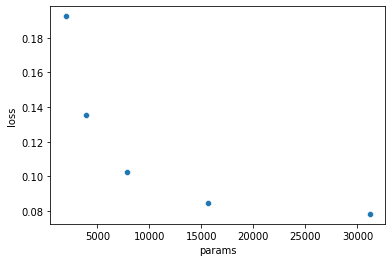

In [16]:
sns.scatterplot(data=df, x="params", y="loss");

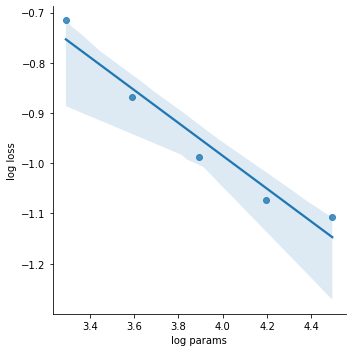

In [17]:
sns.lmplot(data=df, x="log params", y="log loss");

In [18]:
# analyze power law
slope, intercept, r_value, p_value, std_err = stats.linregress(df['log params'],df['log loss'])
print(f"slope: {slope}, intercept: {intercept}")

slope: -0.3275475834580547, intercept: 0.32497329844223855


In [19]:
# Add power law to the dataset
df['power law'] = 10**intercept * df['params']**slope
df

,params,loss,accuracy,log params,log loss,power law
0,1960,0.192474,0.94326,3.292256,-0.715628,0.176442
1,3910,0.135327,0.95974,3.592177,-0.868615,0.140723
2,7810,0.102756,0.96920,3.892651,-0.988194,0.112188
3,15610,0.084668,0.97384,4.193403,-1.072282,0.089420
4,31210,0.078333,0.97536,4.494294,-1.106056,0.071265


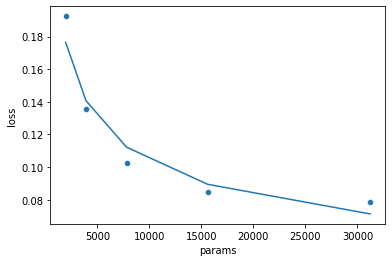

In [20]:
# fit loss curve with power law
sns.scatterplot(data=df, x="params", y="loss")
sns.lineplot(data=df, x="params", y='power law');

### How does validation accuracy behave?

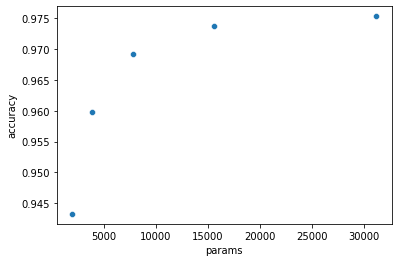

In [21]:
sns.scatterplot(data=df, x="params", y="accuracy");

## Study how the compute-efficient model size varies with compute. This should also follow an approximate power law. Try to estimate its exponent.

In [22]:
# train function that records train_loss and compute used every step
def get_compute_train_loss_data(model, max_epochs=1):
    loss_fn = nn.CrossEntropyLoss()
    learning_rate = LR(model.num_params)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    compute_used = []
    train_loss = []
    
    iters_per_epoch = len(train_loader)
    for epoch in range(max_epochs):
        pbar = tqdm(enumerate(train_loader), total=len(train_loader))
        for it, (images, labels) in pbar:  
            model.train()
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = loss_fn(outputs, labels)
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
            pbar.set_description(f"iter {it}: train loss {loss.item():.5f}")
            
            past_iters = epoch * iters_per_epoch
            # this uses C = 6NBS from the neural scaling laws paper
            compute_used.append(6 * model.num_params * batch_size * (it + 1 + past_iters))
            train_loss.append(loss.item())
    return compute_used, train_loss

num params: 1960


iter 468: train loss 0.31392: 100%|██████████| 469/469 [00:10<00:00, 46.56it/s]


num params: 3910


iter 468: train loss 0.15829: 100%|██████████| 469/469 [00:10<00:00, 45.97it/s]


num params: 7810


iter 468: train loss 0.09757: 100%|██████████| 469/469 [00:10<00:00, 45.82it/s]


num params: 15610


iter 468: train loss 0.08463: 100%|██████████| 469/469 [00:10<00:00, 46.48it/s]


num params: 31210


iter 468: train loss 0.07266: 100%|██████████| 469/469 [00:10<00:00, 45.65it/s]


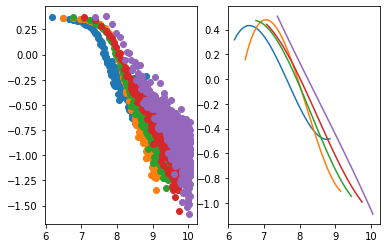

In [23]:
# function to train multiple models and record the data we care about
# also fits the loss curves and keeps track of the polynomials, so that we
# can use them to infer optimal model size later
def fit_loss_vs_compute(num_models, max_epochs=1):
    polys = []
    params = []
    fig, (ax1, ax2) = plt.subplots(1, 2)
    for power in range(num_models):
        model = WideConvNet(scaling_factor=2 ** power).to(device)
        compute, train_loss = get_compute_train_loss_data(model, max_epochs)
        # fit curve
        x = np.log10(compute)
        y = np.log10(train_loss)
        z = np.polyfit(x, y, 3)
        f = np.poly1d(z)

        polys.append(f) 
        params.append(model.num_params)

        # plot log train_loss vs log compute
        x_new = np.linspace(x[0], x[-1], 50)
        y_new = f(x_new)
    
        ax1.scatter(x, y)
        ax2.plot(x_new, y_new)
    plt.show()
    return polys, params

polys, params = fit_loss_vs_compute(num_models=5, max_epochs=1)

In [24]:
# for a given compute value, pick the model with the minimum loss at that point
computes = []
sizes = []
for c in np.linspace(7, 11, 10):
    computes.append(c)
    optimal_size = None
    min_so_far = float('inf')
    for poly, size in zip(polys, params):
        if poly(c) < min_so_far:
            optimal_size = size
            min_so_far = poly(c)
    sizes.append(optimal_size)

In [25]:
data = {'log compute': computes, 'params': sizes}
df = pd.DataFrame(data)
df['log params'] = np.log10(df['params'])
df.head()

,log compute,params,log params
0,7.000000,1960,3.292256
1,7.444444,1960,3.292256
2,7.888889,1960,3.292256
3,8.333333,1960,3.292256
4,8.777778,3910,3.592177


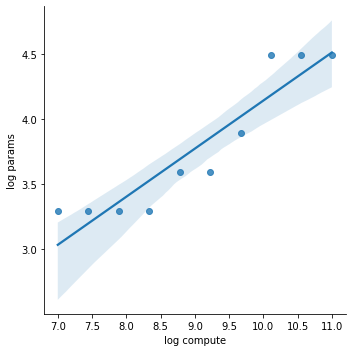

In [26]:
sns.lmplot(data=df, x='log compute', y='log params');

In [27]:
# analyze N_opt(C) power law
slope, intercept, r_value, p_value, std_err = stats.linregress(df['log compute'],df['log params'])
print(f"slope: {slope}, intercept: {intercept}")

slope: 0.3687814981506611, intercept: 0.4538575306531434


## For the dataset size, multiply the fraction of the full dataset used by powers of 2 (i.e. 1, 1/2, 1/4, ...). To reduce noise, use a few random seeds and always use the full validation set.

In [28]:
# train function that will use dataset of size len(train_dataset) // scaling_factor
def train_subset(model, optimizer, scaling_factor):
    model.train()
    print(f"training model with: {model.num_params} parameters")
    train_subset = Subset(train_dataset, range(0, len(train_dataset) // scaling_factor))
    train_loader_subset = DataLoader(dataset=train_subset,
                                    batch_size=batch_size,
                                    shuffle=True)
    print(f"dataset size: {len(train_loader_subset.dataset)}, {1/scaling_factor} of full train_dataset")
    pbar = tqdm(enumerate(train_loader_subset), total=len(train_loader_subset))
    for it, (images, labels) in pbar:  
        images = images.to(device)
        labels = labels.to(device)
        
        #Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)
            
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_description(f"iter {it}: train loss {loss.item():.5f}")

In [29]:
# now train / test multiple dataset sizes to observe dataset size scaling laws
num_datasets = 5
num_trials = 5
dataset_size = [0] * num_datasets
test_loss = [0] * num_datasets
accuracy = [0] * num_datasets
for power in range(num_datasets):
    for _ in range(num_trials):
        model = WideConvNet(scaling_factor=2**5).to(device)
        loss_fn = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=LR(model.num_params))
        train_subset(model, optimizer, scaling_factor=2**power)
        tloss, acc = test(model)
        test_loss[power] += tloss
        accuracy[power] += acc
        print("\n")
    dataset_size[power] = len(train_dataset) // 2**power
    params[power] = model.num_params
    test_loss[power] /= num_trials
    accuracy[power] /= num_trials

num params: 62410
training model with: 62410 parameters
dataset size: 60000, 1.0 of full train_dataset


iter 468: train loss 0.05823: 100%|██████████| 469/469 [00:10<00:00, 44.01it/s]


testing model with 62410 parameters
test loss: 0.07966053610832631
Accuracy of the network on the 10000 test images: 0.9757


num params: 62410
training model with: 62410 parameters
dataset size: 60000, 1.0 of full train_dataset


iter 468: train loss 0.17692: 100%|██████████| 469/469 [00:10<00:00, 44.75it/s]


testing model with 62410 parameters
test loss: 0.0947050946540659
Accuracy of the network on the 10000 test images: 0.9707


num params: 62410
training model with: 62410 parameters
dataset size: 60000, 1.0 of full train_dataset


iter 468: train loss 0.02402: 100%|██████████| 469/469 [00:10<00:00, 44.02it/s]


testing model with 62410 parameters
test loss: 0.08396173478398897
Accuracy of the network on the 10000 test images: 0.9737


num params: 62410
training model with: 62410 parameters
dataset size: 60000, 1.0 of full train_dataset


iter 468: train loss 0.05944: 100%|██████████| 469/469 [00:10<00:00, 44.52it/s]


testing model with 62410 parameters
test loss: 0.06961073274311574
Accuracy of the network on the 10000 test images: 0.9779


num params: 62410
training model with: 62410 parameters
dataset size: 60000, 1.0 of full train_dataset


iter 468: train loss 0.04676: 100%|██████████| 469/469 [00:10<00:00, 44.49it/s]


testing model with 62410 parameters
test loss: 0.07858893600634381
Accuracy of the network on the 10000 test images: 0.9739


num params: 62410
training model with: 62410 parameters
dataset size: 30000, 0.5 of full train_dataset


iter 234: train loss 0.24839: 100%|██████████| 235/235 [00:05<00:00, 44.63it/s]


testing model with 62410 parameters
test loss: 0.10404734322919121
Accuracy of the network on the 10000 test images: 0.9701


num params: 62410
training model with: 62410 parameters
dataset size: 30000, 0.5 of full train_dataset


iter 234: train loss 0.09210: 100%|██████████| 235/235 [00:05<00:00, 44.13it/s]


testing model with 62410 parameters
test loss: 0.10953688306757543
Accuracy of the network on the 10000 test images: 0.9654


num params: 62410
training model with: 62410 parameters
dataset size: 30000, 0.5 of full train_dataset


iter 234: train loss 0.02973: 100%|██████████| 235/235 [00:05<00:00, 43.66it/s]


testing model with 62410 parameters
test loss: 0.10600653517095349
Accuracy of the network on the 10000 test images: 0.9664


num params: 62410
training model with: 62410 parameters
dataset size: 30000, 0.5 of full train_dataset


iter 234: train loss 0.19942: 100%|██████████| 235/235 [00:05<00:00, 44.19it/s]


testing model with 62410 parameters
test loss: 0.09806262520200844
Accuracy of the network on the 10000 test images: 0.9707


num params: 62410
training model with: 62410 parameters
dataset size: 30000, 0.5 of full train_dataset


iter 234: train loss 0.25073: 100%|██████████| 235/235 [00:05<00:00, 44.52it/s]


testing model with 62410 parameters
test loss: 0.10981701625676095
Accuracy of the network on the 10000 test images: 0.9669


num params: 62410
training model with: 62410 parameters
dataset size: 15000, 0.25 of full train_dataset


iter 117: train loss 0.03147: 100%|██████████| 118/118 [00:02<00:00, 44.59it/s]


testing model with 62410 parameters
test loss: 0.18907501001524019
Accuracy of the network on the 10000 test images: 0.944


num params: 62410
training model with: 62410 parameters
dataset size: 15000, 0.25 of full train_dataset


iter 117: train loss 0.04779: 100%|██████████| 118/118 [00:02<00:00, 44.43it/s]


testing model with 62410 parameters
test loss: 0.19921253989391688
Accuracy of the network on the 10000 test images: 0.9388


num params: 62410
training model with: 62410 parameters
dataset size: 15000, 0.25 of full train_dataset


iter 117: train loss 0.13016: 100%|██████████| 118/118 [00:02<00:00, 44.62it/s]


testing model with 62410 parameters
test loss: 0.16084711131038545
Accuracy of the network on the 10000 test images: 0.9574


num params: 62410
training model with: 62410 parameters
dataset size: 15000, 0.25 of full train_dataset


iter 117: train loss 0.07356: 100%|██████████| 118/118 [00:02<00:00, 44.79it/s]


testing model with 62410 parameters
test loss: 0.16545425468607794
Accuracy of the network on the 10000 test images: 0.9554


num params: 62410
training model with: 62410 parameters
dataset size: 15000, 0.25 of full train_dataset


iter 117: train loss 0.30590: 100%|██████████| 118/118 [00:02<00:00, 44.30it/s]


testing model with 62410 parameters
test loss: 0.18497940954528277
Accuracy of the network on the 10000 test images: 0.9467


num params: 62410
training model with: 62410 parameters
dataset size: 7500, 0.125 of full train_dataset


iter 58: train loss 0.21172: 100%|██████████| 59/59 [00:01<00:00, 44.87it/s]


testing model with 62410 parameters
test loss: 0.24402460927450204
Accuracy of the network on the 10000 test images: 0.93


num params: 62410
training model with: 62410 parameters
dataset size: 7500, 0.125 of full train_dataset


iter 58: train loss 0.23641: 100%|██████████| 59/59 [00:01<00:00, 44.63it/s]


testing model with 62410 parameters
test loss: 0.26623655704757837
Accuracy of the network on the 10000 test images: 0.9223


num params: 62410
training model with: 62410 parameters
dataset size: 7500, 0.125 of full train_dataset


iter 58: train loss 0.17312: 100%|██████████| 59/59 [00:01<00:00, 44.90it/s]


testing model with 62410 parameters
test loss: 0.24685086668292178
Accuracy of the network on the 10000 test images: 0.9287


num params: 62410
training model with: 62410 parameters
dataset size: 7500, 0.125 of full train_dataset


iter 58: train loss 0.35389: 100%|██████████| 59/59 [00:01<00:00, 44.87it/s]


testing model with 62410 parameters
test loss: 0.271372509530828
Accuracy of the network on the 10000 test images: 0.9138


num params: 62410
training model with: 62410 parameters
dataset size: 7500, 0.125 of full train_dataset


iter 58: train loss 0.20820: 100%|██████████| 59/59 [00:01<00:00, 44.59it/s]


testing model with 62410 parameters
test loss: 0.23171779136114481
Accuracy of the network on the 10000 test images: 0.9295


num params: 62410
training model with: 62410 parameters
dataset size: 3750, 0.0625 of full train_dataset


iter 29: train loss 0.34274: 100%|██████████| 30/30 [00:00<00:00, 44.33it/s]


testing model with 62410 parameters
test loss: 0.34625492301545563
Accuracy of the network on the 10000 test images: 0.8955


num params: 62410
training model with: 62410 parameters
dataset size: 3750, 0.0625 of full train_dataset


iter 29: train loss 0.47781: 100%|██████████| 30/30 [00:00<00:00, 45.39it/s]


testing model with 62410 parameters
test loss: 0.39107501638841025
Accuracy of the network on the 10000 test images: 0.8876


num params: 62410
training model with: 62410 parameters
dataset size: 3750, 0.0625 of full train_dataset


iter 29: train loss 0.18259: 100%|██████████| 30/30 [00:00<00:00, 45.28it/s]


testing model with 62410 parameters
test loss: 0.3780169090892695
Accuracy of the network on the 10000 test images: 0.8821


num params: 62410
training model with: 62410 parameters
dataset size: 3750, 0.0625 of full train_dataset


iter 29: train loss 0.34397: 100%|██████████| 30/30 [00:00<00:00, 45.55it/s]


testing model with 62410 parameters
test loss: 0.39934263425537303
Accuracy of the network on the 10000 test images: 0.8766


num params: 62410
training model with: 62410 parameters
dataset size: 3750, 0.0625 of full train_dataset


iter 29: train loss 0.20618: 100%|██████████| 30/30 [00:00<00:00, 45.71it/s]


testing model with 62410 parameters
test loss: 0.3414358862593204
Accuracy of the network on the 10000 test images: 0.8992




In [30]:
data = {'dataset_size' : dataset_size, 'loss': test_loss, 'accuracy': accuracy} 
df = pd.DataFrame(data)
df['log dataset_size'] = np.log10(df['dataset_size'])
df['log loss'] = np.log10(df['loss'])
df

,dataset_size,loss,accuracy,log dataset_size,log loss
0,60000,0.081305,0.97438,4.778151,-1.089881
1,30000,0.105494,0.96790,4.477121,-0.976772
2,15000,0.179914,0.94846,4.176091,-0.744936
3,7500,0.252040,0.92486,3.875061,-0.598530
4,3750,0.371225,0.88820,3.574031,-0.430363


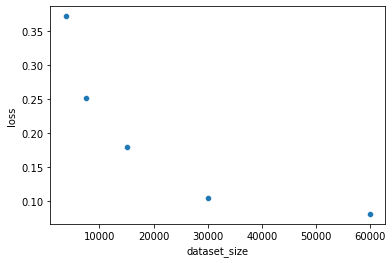

In [31]:
sns.scatterplot(data=df, x="dataset_size", y="loss");

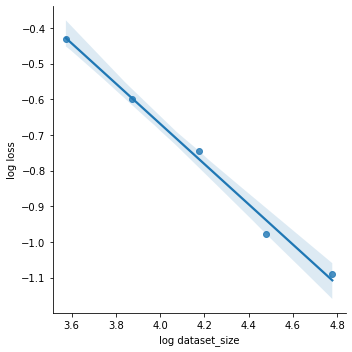

In [32]:
sns.lmplot(data=df, x="log dataset_size", y="log loss");

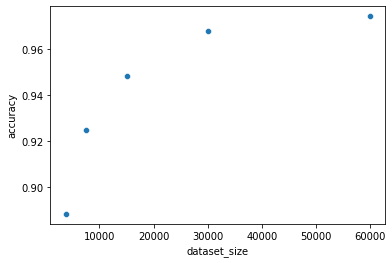

In [33]:
sns.scatterplot(data=df, x="dataset_size", y="accuracy");

In [34]:
# analyze L(D) power law
slope, intercept, r_value, p_value, std_err = stats.linregress(df['log dataset_size'],df['log loss'])
print(f"slope: {slope}, intercept: {intercept}")

slope: -0.5638235252142583, intercept: 1.5864823447408833


## Repeat your entire experiment with 20% dropout to see how this affects the scaling exponents.

First, parameter scaling laws

In [35]:
# now train / test all models to observe scaling laws
# scaling factors: 2^0, 2^1, 2^2, ... 
num_models = 5
num_trials = 5
params = [0] * num_models
test_loss = [0] * num_models
accuracy = [0] * num_models
for power in range(num_models):
    for _ in range(num_trials):
        model = WideConvNet(scaling_factor=2**power, dropout=0.2).to(device)
        loss_fn = nn.CrossEntropyLoss()
        learning_rate = LR(model.num_params)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        train(model, optimizer)
        tloss, acc = test(model)
        test_loss[power] += tloss
        accuracy[power] += acc
        print("\n")
    test_loss[power] /= num_trials
    accuracy[power] /= num_trials
    params[power] = model.num_params

num params: 1960
training model with 1960 parameters


iter 468: train loss 0.23715: 100%|██████████| 469/469 [00:10<00:00, 45.92it/s]


testing model with 1960 parameters
test loss: 0.2040230869492398
Accuracy of the network on the 10000 test images: 0.9441


num params: 1960
training model with 1960 parameters


iter 468: train loss 0.44404: 100%|██████████| 469/469 [00:10<00:00, 45.55it/s]


testing model with 1960 parameters
test loss: 0.2645751539664932
Accuracy of the network on the 10000 test images: 0.9261


num params: 1960
training model with 1960 parameters


iter 468: train loss 0.46091: 100%|██████████| 469/469 [00:10<00:00, 46.04it/s]


testing model with 1960 parameters
test loss: 0.258311489809163
Accuracy of the network on the 10000 test images: 0.9274


num params: 1960
training model with 1960 parameters


iter 468: train loss 0.46840: 100%|██████████| 469/469 [00:10<00:00, 46.06it/s]


testing model with 1960 parameters
test loss: 0.27913348150404194
Accuracy of the network on the 10000 test images: 0.9243


num params: 1960
training model with 1960 parameters


iter 468: train loss 0.59102: 100%|██████████| 469/469 [00:10<00:00, 45.77it/s]


testing model with 1960 parameters
test loss: 0.22089550361225876
Accuracy of the network on the 10000 test images: 0.9376


num params: 3910
training model with 3910 parameters


iter 468: train loss 0.22586: 100%|██████████| 469/469 [00:10<00:00, 45.69it/s]


testing model with 3910 parameters
test loss: 0.20466308795575855
Accuracy of the network on the 10000 test images: 0.9373


num params: 3910
training model with 3910 parameters


iter 468: train loss 0.19986: 100%|██████████| 469/469 [00:10<00:00, 46.06it/s]


testing model with 3910 parameters
test loss: 0.14691005732062495
Accuracy of the network on the 10000 test images: 0.9579


num params: 3910
training model with 3910 parameters


iter 468: train loss 0.21072: 100%|██████████| 469/469 [00:10<00:00, 45.70it/s]


testing model with 3910 parameters
test loss: 0.19000075370827807
Accuracy of the network on the 10000 test images: 0.9482


num params: 3910
training model with 3910 parameters


iter 468: train loss 0.24704: 100%|██████████| 469/469 [00:10<00:00, 45.40it/s]


testing model with 3910 parameters
test loss: 0.14416493697068358
Accuracy of the network on the 10000 test images: 0.9595


num params: 3910
training model with 3910 parameters


iter 468: train loss 0.23263: 100%|██████████| 469/469 [00:10<00:00, 45.63it/s]


testing model with 3910 parameters
test loss: 0.16003719123103952
Accuracy of the network on the 10000 test images: 0.9558


num params: 7810
training model with 7810 parameters


iter 468: train loss 0.20107: 100%|██████████| 469/469 [00:10<00:00, 45.82it/s]


testing model with 7810 parameters
test loss: 0.11441536445783664
Accuracy of the network on the 10000 test images: 0.9664


num params: 7810
training model with 7810 parameters


iter 468: train loss 0.25850: 100%|██████████| 469/469 [00:10<00:00, 44.85it/s]


testing model with 7810 parameters
test loss: 0.11914568488733678
Accuracy of the network on the 10000 test images: 0.9656


num params: 7810
training model with 7810 parameters


iter 468: train loss 0.16534: 100%|██████████| 469/469 [00:10<00:00, 45.37it/s]


testing model with 7810 parameters
test loss: 0.11215377679165406
Accuracy of the network on the 10000 test images: 0.9678


num params: 7810
training model with 7810 parameters


iter 468: train loss 0.14989: 100%|██████████| 469/469 [00:10<00:00, 45.71it/s]


testing model with 7810 parameters
test loss: 0.11094096732101863
Accuracy of the network on the 10000 test images: 0.9656


num params: 7810
training model with 7810 parameters


iter 468: train loss 0.24612: 100%|██████████| 469/469 [00:10<00:00, 45.77it/s]


testing model with 7810 parameters
test loss: 0.11876446885775917
Accuracy of the network on the 10000 test images: 0.9657


num params: 15610
training model with 15610 parameters


iter 468: train loss 0.07799: 100%|██████████| 469/469 [00:10<00:00, 45.57it/s]


testing model with 15610 parameters
test loss: 0.09215162378511851
Accuracy of the network on the 10000 test images: 0.9705


num params: 15610
training model with 15610 parameters


iter 468: train loss 0.23290: 100%|██████████| 469/469 [00:10<00:00, 45.97it/s]


testing model with 15610 parameters
test loss: 0.08368858720965777
Accuracy of the network on the 10000 test images: 0.9745


num params: 15610
training model with 15610 parameters


iter 468: train loss 0.09874: 100%|██████████| 469/469 [00:10<00:00, 45.88it/s]


testing model with 15610 parameters
test loss: 0.08247206895317458
Accuracy of the network on the 10000 test images: 0.9741


num params: 15610
training model with 15610 parameters


iter 468: train loss 0.12965: 100%|██████████| 469/469 [00:10<00:00, 45.67it/s]


testing model with 15610 parameters
test loss: 0.09261850036586387
Accuracy of the network on the 10000 test images: 0.9726


num params: 15610
training model with 15610 parameters


iter 468: train loss 0.10013: 100%|██████████| 469/469 [00:10<00:00, 45.90it/s]


testing model with 15610 parameters
test loss: 0.08959176831088866
Accuracy of the network on the 10000 test images: 0.9716


num params: 31210
training model with 31210 parameters


iter 468: train loss 0.04575: 100%|██████████| 469/469 [00:10<00:00, 45.89it/s]


testing model with 31210 parameters
test loss: 0.08637915466782413
Accuracy of the network on the 10000 test images: 0.9714


num params: 31210
training model with 31210 parameters


iter 468: train loss 0.17400: 100%|██████████| 469/469 [00:10<00:00, 45.62it/s]


testing model with 31210 parameters
test loss: 0.0784622040117466
Accuracy of the network on the 10000 test images: 0.9762


num params: 31210
training model with 31210 parameters


iter 468: train loss 0.14116: 100%|██████████| 469/469 [00:10<00:00, 44.87it/s]


testing model with 31210 parameters
test loss: 0.08689347869138929
Accuracy of the network on the 10000 test images: 0.9731


num params: 31210
training model with 31210 parameters


iter 468: train loss 0.02198: 100%|██████████| 469/469 [00:10<00:00, 45.62it/s]


testing model with 31210 parameters
test loss: 0.07707963362807714
Accuracy of the network on the 10000 test images: 0.9758


num params: 31210
training model with 31210 parameters


iter 468: train loss 0.11894: 100%|██████████| 469/469 [00:10<00:00, 45.92it/s]


testing model with 31210 parameters
test loss: 0.07753766087602966
Accuracy of the network on the 10000 test images: 0.9754




In [36]:
data = {'params' : params, 'loss': test_loss, 'accuracy': accuracy} 
df = pd.DataFrame(data)
df['log params'] = np.log10(df['params'])
df['log loss'] = np.log10(df['loss'])
df

,params,loss,accuracy,log params,log loss
0,1960,0.245388,0.93190,3.292256,-0.610147
1,3910,0.169155,0.95174,3.592177,-0.771715
2,7810,0.115084,0.96622,3.892651,-0.938985
3,15610,0.088105,0.97266,4.193403,-1.055002
4,31210,0.081270,0.97438,4.494294,-1.090067


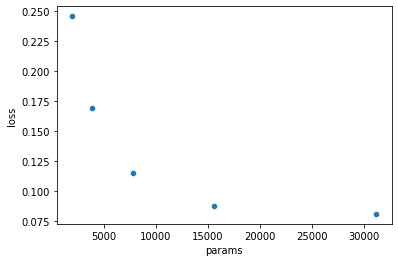

In [37]:
sns.scatterplot(data=df, x="params", y="loss");

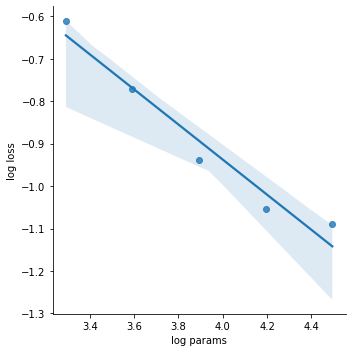

In [38]:
sns.lmplot(data=df, x="log params", y="log loss");

In [39]:
# analyze L(N) power law
slope, intercept, r_value, p_value, std_err = stats.linregress(df['log params'],df['log loss'])
print(f"slope: {slope}, intercept: {intercept}")

slope: -0.41359547547497794, intercept: 0.716925843372978


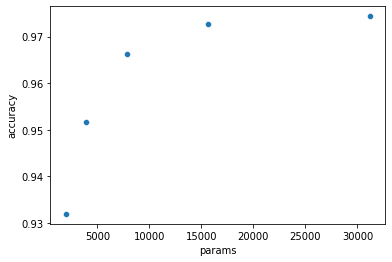

In [40]:
sns.scatterplot(data=df, x="params", y="accuracy")

Compute-efficient frontier / optimal model size scaling laws

In [41]:
# train function that records loss vs compute
def get_compute_train_loss_data(model, max_epochs=1):
    loss_fn = nn.CrossEntropyLoss()
    learning_rate = LR(model.num_params)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    compute_used = []
    train_loss = []
    
    iters_per_epoch = len(train_loader)
    for epoch in range(max_epochs):
        pbar = tqdm(enumerate(train_loader), total=len(train_loader))
        for it, (images, labels) in pbar:  
            model.train()
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = loss_fn(outputs, labels)
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
            pbar.set_description(f"iter {it}: train loss {loss.item():.5f}")
            
            past_iters = epoch * iters_per_epoch
            # this uses C = 6NBS from the neural scaling laws paper
            compute_used.append(6 * model.num_params * batch_size * (it + 1 + past_iters))
            train_loss.append(loss.item())
    return compute_used, train_loss

num params: 1960


iter 468: train loss 0.21100: 100%|██████████| 469/469 [00:10<00:00, 46.15it/s]


num params: 3910


iter 468: train loss 0.38331: 100%|██████████| 469/469 [00:10<00:00, 46.25it/s]


num params: 7810


iter 468: train loss 0.33972: 100%|██████████| 469/469 [00:10<00:00, 46.10it/s]


num params: 15610


iter 468: train loss 0.09647: 100%|██████████| 469/469 [00:10<00:00, 45.94it/s]


num params: 31210


iter 468: train loss 0.07057: 100%|██████████| 469/469 [00:10<00:00, 45.99it/s]


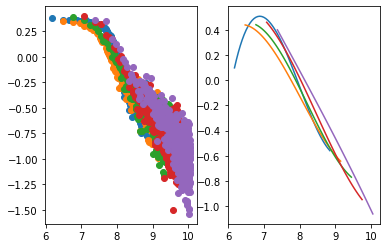

In [42]:
# function to train multiple models and record the data we care about
# also fits the loss curves and keeps track of the polynomials, so that we
# can use them to infer optimal model size later
def plot_loss_vs_train_compute(num_models, max_epochs=1):
    df = pd.DataFrame()
    funcs = []
    params = []
    fig, (ax1, ax2) = plt.subplots(1, 2)
    for power in range(num_models):
        temp_df = pd.DataFrame()
        model = WideConvNet(scaling_factor=2**power, dropout=0.2).to(device)
        compute, train_loss = get_compute_train_loss_data(model, max_epochs)
        temp_df['compute'] = compute
        temp_df['train_loss'] = train_loss
        temp_df['log compute'] = np.log10(compute)
        temp_df['log train_loss'] = np.log10(train_loss)
        temp_df['modelsize'] = model.num_params
        # fit curve
        x = temp_df['log compute'].values
        y = temp_df['log train_loss'].values
        z = np.polyfit(x, y, 3)
        f = np.poly1d(z)

        funcs.append(f) 
        params.append(model.num_params)

        # plot log train_loss vs log compute
        x_new = np.linspace(x[0], x[-1], 50)
        y_new = f(x_new)
    
        ax2.plot(x_new, y_new)
        ax1.scatter(np.log10(compute), np.log10(train_loss))
        df = df.append(temp_df)
    plt.show()
    return df, funcs, params

df, polys, params = plot_loss_vs_train_compute(num_models=5, max_epochs=1)

In [43]:
# for a given compute value, pick the model with the minimum loss at that point
computes = []
sizes = []
for c in np.linspace(7, 11, 10):
    computes.append(c)
    optimal_size = None
    min_so_far = float('inf')
    for poly, size in zip(polys, params):
        if poly(c) < min_so_far:
            optimal_size = size
            min_so_far = poly(c)
    sizes.append(optimal_size)

In [44]:
data = {'log compute': computes, 'params': sizes}
df = pd.DataFrame(data)
df['log params'] = np.log10(df['params'])
df.head()

,log compute,params,log params
0,7.000000,3910,3.592177
1,7.444444,3910,3.592177
2,7.888889,3910,3.592177
3,8.333333,3910,3.592177
4,8.777778,1960,3.292256


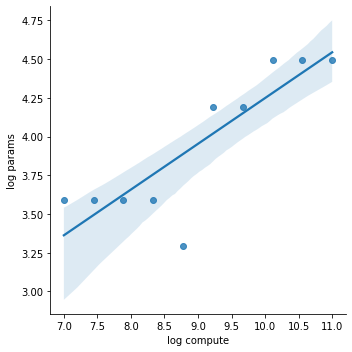

In [45]:
sns.lmplot(data=df, x='log compute', y='log params');

In [46]:
# analyze N_opt(C) power law
slope, intercept, r_value, p_value, std_err = stats.linregress(df['log compute'],df['log params'])
print(f"slope: {slope}, intercept: {intercept}")

slope: 0.29521748870951436, intercept: 1.2961076229204473


Finally, dataset size scaling laws

In [47]:
# new train function that will take dataset scaling_factor arg
# we use dataset size of len(train_dataset) // scaling_factor
# we will use powers of 2: 1, 2, 4, 8, 16
def train_subset(model, optimizer, scaling_factor):
    model.train()
    print(f"training model with: {model.num_params} parameters")
    train_subset = torch.utils.data.Subset(train_dataset, range(0, len(train_dataset) // scaling_factor))
    train_loader_subset = torch.utils.data.DataLoader(dataset=train_subset,
                                           batch_size=batch_size,
                                           shuffle=True)
    print(f"dataset size: {len(train_loader_subset.dataset)}, {1/scaling_factor} of full train_dataset")
    pbar = tqdm(enumerate(train_loader_subset), total=len(train_loader_subset))
    for it, (images, labels) in pbar:  
        images = images.to(device)
        labels = labels.to(device)
        
        #Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)
            
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_description(f"iter {it}: train loss {loss.item():.5f}")

In [48]:
model = WideConvNet(scaling_factor=2**5, dropout=0.2).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR(model.num_params))

num params: 62410


In [49]:
# now train / test multiple models to observe dataset size scaling laws
# scaling factors: sqrt(2)^0, sqrt(2)^1, ..., sqrt(2)^4
num_datasets = 5
num_trials = 5
dataset_size = [0] * num_datasets
test_loss = [0] * num_datasets
accuracy = [0] * num_datasets
for power in range(num_datasets):
    for _ in range(num_trials):
        model = WideConvNet(scaling_factor=2**5, dropout=0.2).to(device)
        loss_fn = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=LR(model.num_params))
        train_subset(model, optimizer, scaling_factor=2**power)
        tloss, acc = test(model)
        test_loss[power] += tloss
        accuracy[power] += acc
        print("\n")
    dataset_size[power] = len(train_dataset) // 2**power
    params[power] = model.num_params
    test_loss[power] /= num_trials
    accuracy[power] /= num_trials

num params: 62410
training model with: 62410 parameters
dataset size: 60000, 1.0 of full train_dataset


iter 468: train loss 0.10598: 100%|██████████| 469/469 [00:10<00:00, 44.19it/s]


testing model with 62410 parameters
test loss: 0.06447689928397347
Accuracy of the network on the 10000 test images: 0.9797


num params: 62410
training model with: 62410 parameters
dataset size: 60000, 1.0 of full train_dataset


iter 468: train loss 0.12178: 100%|██████████| 469/469 [00:10<00:00, 44.99it/s]


testing model with 62410 parameters
test loss: 0.06739018496738959
Accuracy of the network on the 10000 test images: 0.9781


num params: 62410
training model with: 62410 parameters
dataset size: 60000, 1.0 of full train_dataset


iter 468: train loss 0.13403: 100%|██████████| 469/469 [00:10<00:00, 44.94it/s]


testing model with 62410 parameters
test loss: 0.078398677732654
Accuracy of the network on the 10000 test images: 0.9747


num params: 62410
training model with: 62410 parameters
dataset size: 60000, 1.0 of full train_dataset


iter 468: train loss 0.03857: 100%|██████████| 469/469 [00:10<00:00, 44.28it/s]


testing model with 62410 parameters
test loss: 0.0959892392960153
Accuracy of the network on the 10000 test images: 0.9699


num params: 62410
training model with: 62410 parameters
dataset size: 60000, 1.0 of full train_dataset


iter 468: train loss 0.10744: 100%|██████████| 469/469 [00:10<00:00, 44.60it/s]


testing model with 62410 parameters
test loss: 0.07648274378520967
Accuracy of the network on the 10000 test images: 0.9748


num params: 62410
training model with: 62410 parameters
dataset size: 30000, 0.5 of full train_dataset


iter 234: train loss 0.09117: 100%|██████████| 235/235 [00:05<00:00, 45.13it/s]


testing model with 62410 parameters
test loss: 0.10428448101576371
Accuracy of the network on the 10000 test images: 0.97


num params: 62410
training model with: 62410 parameters
dataset size: 30000, 0.5 of full train_dataset


iter 234: train loss 0.09685: 100%|██████████| 235/235 [00:05<00:00, 44.82it/s]


testing model with 62410 parameters
test loss: 0.10793845812919774
Accuracy of the network on the 10000 test images: 0.968


num params: 62410
training model with: 62410 parameters
dataset size: 30000, 0.5 of full train_dataset


iter 234: train loss 0.20024: 100%|██████████| 235/235 [00:05<00:00, 43.96it/s]


testing model with 62410 parameters
test loss: 0.10030072189490252
Accuracy of the network on the 10000 test images: 0.9685


num params: 62410
training model with: 62410 parameters
dataset size: 30000, 0.5 of full train_dataset


iter 234: train loss 0.16679: 100%|██████████| 235/235 [00:05<00:00, 44.32it/s]


testing model with 62410 parameters
test loss: 0.1123924967420252
Accuracy of the network on the 10000 test images: 0.9657


num params: 62410
training model with: 62410 parameters
dataset size: 30000, 0.5 of full train_dataset


iter 234: train loss 0.24935: 100%|██████████| 235/235 [00:05<00:00, 44.81it/s]


testing model with 62410 parameters
test loss: 0.09564858443940742
Accuracy of the network on the 10000 test images: 0.9716


num params: 62410
training model with: 62410 parameters
dataset size: 15000, 0.25 of full train_dataset


iter 117: train loss 0.05290: 100%|██████████| 118/118 [00:02<00:00, 45.29it/s]


testing model with 62410 parameters
test loss: 0.14638515906054764
Accuracy of the network on the 10000 test images: 0.9596


num params: 62410
training model with: 62410 parameters
dataset size: 15000, 0.25 of full train_dataset


iter 117: train loss 0.03014: 100%|██████████| 118/118 [00:02<00:00, 44.92it/s]


testing model with 62410 parameters
test loss: 0.1356265146898318
Accuracy of the network on the 10000 test images: 0.961


num params: 62410
training model with: 62410 parameters
dataset size: 15000, 0.25 of full train_dataset


iter 117: train loss 0.19981: 100%|██████████| 118/118 [00:02<00:00, 45.42it/s]


testing model with 62410 parameters
test loss: 0.1718786759655687
Accuracy of the network on the 10000 test images: 0.9508


num params: 62410
training model with: 62410 parameters
dataset size: 15000, 0.25 of full train_dataset


iter 117: train loss 0.11895: 100%|██████████| 118/118 [00:02<00:00, 44.05it/s]


testing model with 62410 parameters
test loss: 0.15948483196994925
Accuracy of the network on the 10000 test images: 0.9558


num params: 62410
training model with: 62410 parameters
dataset size: 15000, 0.25 of full train_dataset


iter 117: train loss 0.26445: 100%|██████████| 118/118 [00:02<00:00, 45.34it/s]


testing model with 62410 parameters
test loss: 0.15276758896210527
Accuracy of the network on the 10000 test images: 0.9566


num params: 62410
training model with: 62410 parameters
dataset size: 7500, 0.125 of full train_dataset


iter 58: train loss 0.36799: 100%|██████████| 59/59 [00:01<00:00, 45.19it/s]


testing model with 62410 parameters
test loss: 0.2357311686383018
Accuracy of the network on the 10000 test images: 0.9326


num params: 62410
training model with: 62410 parameters
dataset size: 7500, 0.125 of full train_dataset


iter 58: train loss 0.22644: 100%|██████████| 59/59 [00:01<00:00, 45.57it/s]


testing model with 62410 parameters
test loss: 0.23604261398881296
Accuracy of the network on the 10000 test images: 0.9347


num params: 62410
training model with: 62410 parameters
dataset size: 7500, 0.125 of full train_dataset


iter 58: train loss 0.33980: 100%|██████████| 59/59 [00:01<00:00, 45.37it/s]


testing model with 62410 parameters
test loss: 0.25169889647749405
Accuracy of the network on the 10000 test images: 0.9253


num params: 62410
training model with: 62410 parameters
dataset size: 7500, 0.125 of full train_dataset


iter 58: train loss 0.21701: 100%|██████████| 59/59 [00:01<00:00, 44.89it/s]


testing model with 62410 parameters
test loss: 0.2313033285774762
Accuracy of the network on the 10000 test images: 0.9339


num params: 62410
training model with: 62410 parameters
dataset size: 7500, 0.125 of full train_dataset


iter 58: train loss 0.18001: 100%|██████████| 59/59 [00:01<00:00, 45.04it/s]


testing model with 62410 parameters
test loss: 0.22788008830592602
Accuracy of the network on the 10000 test images: 0.9346


num params: 62410
training model with: 62410 parameters
dataset size: 3750, 0.0625 of full train_dataset


iter 29: train loss 0.42222: 100%|██████████| 30/30 [00:00<00:00, 46.13it/s]


testing model with 62410 parameters
test loss: 0.3612667357997049
Accuracy of the network on the 10000 test images: 0.8963


num params: 62410
training model with: 62410 parameters
dataset size: 3750, 0.0625 of full train_dataset


iter 29: train loss 0.40160: 100%|██████████| 30/30 [00:00<00:00, 45.82it/s]


testing model with 62410 parameters
test loss: 0.38774959714729573
Accuracy of the network on the 10000 test images: 0.8876


num params: 62410
training model with: 62410 parameters
dataset size: 3750, 0.0625 of full train_dataset


iter 29: train loss 0.15264: 100%|██████████| 30/30 [00:00<00:00, 46.57it/s]


testing model with 62410 parameters
test loss: 0.38050877802734134
Accuracy of the network on the 10000 test images: 0.8807


num params: 62410
training model with: 62410 parameters
dataset size: 3750, 0.0625 of full train_dataset


iter 29: train loss 0.25631: 100%|██████████| 30/30 [00:00<00:00, 45.90it/s]


testing model with 62410 parameters
test loss: 0.33764583872088905
Accuracy of the network on the 10000 test images: 0.8998


num params: 62410
training model with: 62410 parameters
dataset size: 3750, 0.0625 of full train_dataset


iter 29: train loss 0.34571: 100%|██████████| 30/30 [00:00<00:00, 46.31it/s]


testing model with 62410 parameters
test loss: 0.3858008975092369
Accuracy of the network on the 10000 test images: 0.8844




In [50]:
data = {'dataset_size' : dataset_size, 'loss': test_loss, 'accuracy': accuracy} 
df = pd.DataFrame(data)
df['log dataset_size'] = np.log10(df['dataset_size'])
df['log loss'] = np.log10(df['loss'])
df

,dataset_size,loss,accuracy,log dataset_size,log loss
0,60000,0.076548,0.97544,4.778151,-1.116069
1,30000,0.104113,0.96876,4.477121,-0.982495
2,15000,0.153229,0.95676,4.176091,-0.814660
3,7500,0.236531,0.93222,3.875061,-0.626112
4,3750,0.370594,0.88976,3.574031,-0.431101


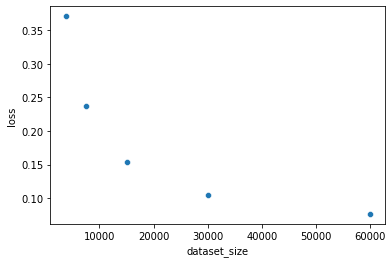

In [51]:
sns.scatterplot(data=df, x="dataset_size", y="loss")

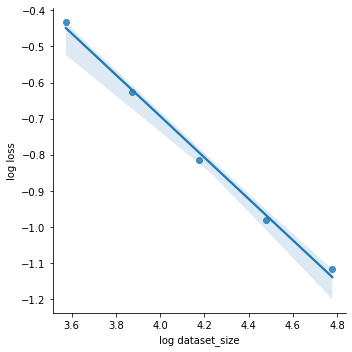

In [52]:
sns.lmplot(data=df, x="log dataset_size", y="log loss");

In [53]:
# analyze L(D) power law
slope, intercept, r_value, p_value, std_err = stats.linregress(df['log dataset_size'],df['log loss'])
print(f"slope: {slope}, intercept: {intercept}")

slope: -0.5734706852391981, intercept: 1.6007785211217505


In this run, it looks like the dropout didn't make much of a difference...